# Covid Explainer Introduction

This Covid explainer will walk you through how to run the MDP Algorithm on the code (in the version used by `covid_team2`). Everything you need to run the code should already be here in this folder, as the MDP algorithm was modified for Covid specifically. Relevant files in this directory include: 
* `mdp_model.py`
* `mdp_clustering.py`
* `mdp_testing.py`
* `mdp_tools.py`
* `states_combined_data.csv`**

** Note: some rows or columns have been taken out to create this sample dataset, to accomodate missing data in the original dataset. 

## Creating Training Data

We will run one round of the demonstration that trains on data that ends at a date earlier than the last date we have on our dataset. This way we can compare how well our model predicts to the real value in our data. The last date in this `states_combined_data.csv` contains up to `5/29/20`. 

In [ ]:
# Load Built-in Modules
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pickle

# Ignore Python package warnings (not verbose)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# paths
DIRECTORY_PATH = os.path.dirname(os.getcwd())
os.chdir(DIRECTORY_PATH)

DATA_PATH   = os.path.join(os.getcwd(), "data", "input")
RESULT_PATH = os.path.join(os.path.dirname(os.getcwd()), "results")
MODEL_PATH  = os.path.join(os.getcwd(), "models")

In [3]:
# experiment name
EXPERIMENT_FOLDER = "01 - Cross-validation by state"
try: 
    assert os.path.exists(os.path.join(RESULT_PATH, EXPERIMENT_FOLDER))
except AssertionError:
    os.makedirs(os.path.join(RESULT_PATH, EXPERIMENT_FOLDER))

In [4]:
# Load MDP packages
import codes.mdp_model as mdp
from codes.mdp_testing import mape, plot_pred
from codes.mdp_states_functions import createSamples
# from codes.utils import run_script # for multiprocessing

In [5]:
file = '06_15_2020_states_combined.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file))

In [6]:
# check the number of missing values
for col in df.columns:
    print(col, df[col].isnull().sum())

Unnamed: 0 0
state 0
date 0
cases 0
deaths 0
population 288
emergdec 0
schoolclose 0
gathrestrict25 0
gathrestrictany 0
otherbusinessclose 0
restaurantrestrict 0
gathrestrict10 0
caseisolation 0
stayathome 0
publicmask 0
quarantine 0
nebusinessclose 0
travelrestrictintra 0
gathrestrict50 0
gathrecomany 0
gathrestrict250 0
gathrestrict5 0
gathrestrict1000 0
gathrestrict100 0
gathrestrict3 0
travelrestrictexit 0
travelrestrictentry 0
gathrestrict500 0
retail_and_recreation 2538
grocery_and_pharmacy 2538
parks 2553
transit_stations 2538
workplaces 2538
residential 2538
recovered 5717
active 4715
incident_rate 4824
people_tested 4824
people_hospitalized 5973
mortality_rate 4761
testing_rate 4824
hospitalization_rate 5973
home_time 1321
percentage 1321
full_time 1321
part_time 1321
non_home_time 1321
distance 1334


In [7]:
#     # Exception states
#     df = df[df[region_colname]!='Guam']
#     df = df[df[region_colname]!='Northern Mariana Islands']
#     df = df[df[region_colname]!='Puerto Rico']
#     df = df[df[region_colname]!='Diamond Princess']
#     df = df[df[region_colname]!='Grand Princess']
#     df = df[df[region_colname]!='American Samoa']
#     df = df[df[region_colname]!='Virgin Islands']

In [8]:
np.corrcoef(df["transit_stations"].values, df["home_time"].values)

array([[nan, nan],
       [nan, nan]])

In [9]:
df_nan = df.loc[:, df.isnull().mean() < 0.1]

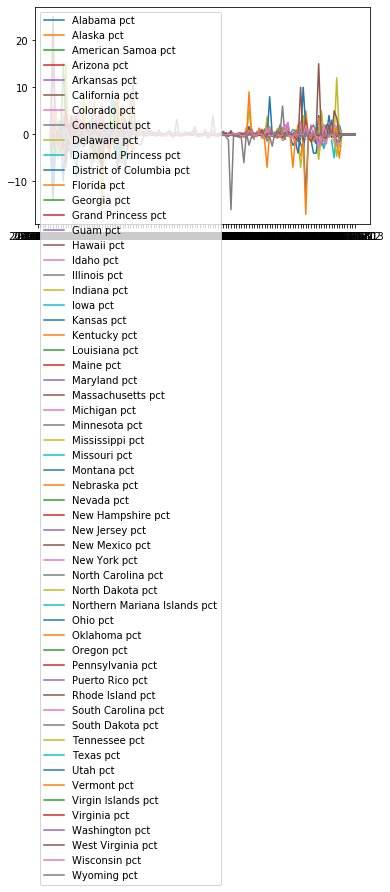

In [14]:
# plotting for a specific feature by region

feature = "transit_stations"
for name, group in df.groupby("state"):
    # group.plot(x="date", y=feature, label=name)
    # plt.plot(group["date"], group[feature], label=name)
    plt.plot(group["date"], group[feature].pct_change(), label=(name+" pct"))
    # plt.plot(group["date"], group[feature].diff(), label=(name+" diff"))
plt.legend()
plt.show()

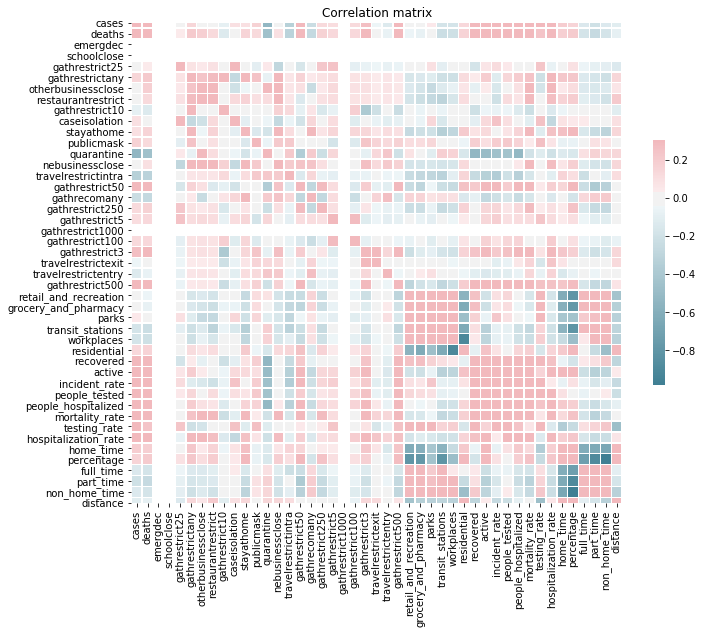

In [9]:
# plot for the covariance matrix between features 
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.loc[:, ~(df.columns.isin(["Unnamed: 0", "state", "date", "population"]))].dropna().corr(method="spearman"), cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation matrix")
plt.show()

We can specify a value `n_days` to create a training dataset that ends `n_days` before this last date. We will also need to give the name of the date column from our `df`. 

In [10]:
n_days = 15
date_col = 'date'

# take out dates for prediction
df.loc[:, [date_col]]= pd.to_datetime(df[date_col])
split_date = df[date_col].max() - timedelta(n_days)
df_train = df.loc[df[date_col] <= split_date]
df_train

,Unnamed: 0,state,date,cases,deaths,population,emergdec,schoolclose,gathrestrict25,gathrestrictany,...,people_hospitalized,mortality_rate,testing_rate,hospitalization_rate,home_time,percentage,full_time,part_time,non_home_time,distance
0,0,Alabama,2020-01-22,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,704.0,64.0,0.835616,1.333333,341.0,9297.0
1,1,Alabama,2020-01-23,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,717.0,65.0,0.772727,1.218182,338.0,9057.0
2,2,Alabama,2020-01-24,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,663.0,63.0,0.777778,1.333333,349.0,9247.0
3,3,Alabama,2020-01-25,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,811.0,80.0,0.142857,0.533333,176.0,9830.0
4,4,Alabama,2020-01-26,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,910.0,85.0,0.120000,0.446809,143.0,7953.0
5,5,Alabama,2020-01-27,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,727.0,65.0,0.809524,1.235294,343.0,8901.0
6,6,Alabama,2020-01-28,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,708.0,64.0,0.837838,1.292683,352.0,9010.0
7,7,Alabama,2020-01-29,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,719.0,64.0,0.842105,1.333333,356.0,9036.0
8,8,Alabama,2020-01-30,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,700.0,64.0,0.833333,1.380952,358.0,9175.0
9,9,Alabama,2020-01-31,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,664.0,63.0,0.800000,1.450000,358.0,9342.0


## Creating Samples

Usually at this point we will set all the parameters that we use to run `model.fit`, but first I want to show you how the actual training samples are created from the data given (which usually happens within `model.fit`). 

Now this is a very important part! We need to specify a `target` value that our model aims to predict from the training data. The few other things we have to specify include `date_col`, `region_col` and `feature_cols`. `region_col` is the name of the area we are measuring, such as `'state'`, while `feature_cols` are a list of strings we want to use as features, such as `['home_time']`. 

`d_avg` is the number of days we want to average when creating each datapoint, which can help decrease noise if there is a sudden spike in cases at a certain day. 

In [13]:
# Setting parameters
target_colname = 'deaths'
region_colname = 'state'
date_colname = 'date'
feature_cols = ['home_time', 'part_time']
days_avg = 3

The other parameters relevant to creating samples include an `action_thresh`, which is a list of ints that create cutoff brackets for actions. When `action_thresh` is an empty list `[]`, the default `ACTION = 0` for all datapoints. For example (the other features will be explained below too!):

In [14]:
action_thresh = []
df_samples, pfeatures = createSamples(df, target_colname, region_colname, date_colname, feature_cols, action_thresh, days_avg)
df_samples

,ID,TIME,home_time,part_time,home_time-1,home_time-2,part_time-1,part_time-2,r_t,r_t-1,r_t-2,RISK,ACTION,state,deaths
0,0,2020-03-28,914.000000,0.179228,801.333333,801.333333,0.319707,0.319707,4.000000,0.000000,0.000000,1.386294,0,Alabama,8.000000
1,0,2020-03-31,838.000000,0.244551,914.000000,801.333333,0.179228,0.319707,3.416667,4.000000,0.000000,1.228665,0,Alabama,27.333333
2,0,2020-04-03,967.000000,0.169411,838.000000,914.000000,0.244551,0.179228,1.548780,3.416667,4.000000,0.437468,0,Alabama,42.333333
3,0,2020-04-06,876.666667,0.217738,967.000000,838.000000,0.169411,0.244551,1.409449,1.548780,3.416667,0.343199,0,Alabama,59.666667
4,0,2020-04-09,893.666667,0.203676,876.666667,967.000000,0.217738,0.169411,1.351955,1.409449,1.548780,0.301552,0,Alabama,80.666667
5,0,2020-04-12,949.333333,0.182855,893.666667,876.666667,0.203676,0.217738,1.264463,1.351955,1.409449,0.234647,0,Alabama,102.000000
6,0,2020-04-15,875.000000,0.285692,949.333333,893.666667,0.182855,0.203676,1.303922,1.264463,1.351955,0.265376,0,Alabama,133.000000
7,0,2020-04-18,981.333333,0.148714,875.000000,949.333333,0.285692,0.182855,1.185464,1.303922,1.264463,0.170134,0,Alabama,157.666667
8,0,2020-04-21,828.666667,0.266863,981.333333,875.000000,0.148714,0.285692,1.228330,1.185464,1.303922,0.205655,0,Alabama,193.666667
9,0,2020-04-24,908.000000,0.217477,828.666667,981.333333,0.266863,0.148714,1.096386,1.228330,1.185464,0.092019,0,Alabama,212.333333


`createSamples` has taken out some of the smaller regions with missing data, and left only the 50 states + Washington DC. It has then assigned each state to an `ID` number, and compressed the `TIME` to be one datapoint for every `n_days`. 

Next, notice that it has created a `target-1` (`cases-1` here) and `target-2` column, as well as `-1` and `-2` columns for each of the features in `feature_cols`. These are the offsets of 1 or 2 datapoints prior to the current point , respectively. At the beginning of each `ID`, when `-1` and `-2` in the features are empty, we simply substitute in the current value of the feature. 

You will also see the `r_t` rows. This is the ratio of the target value today compared to (divided by) the target value at the data point prior. `RISK` (reward) is assigned as the natural log of the `r_t` value. Note that we have also deleted the rows where `target = 0`, since this is before any of the cases have occured, and will throw an error when calculating `r_t`. 

Now, if we specify `action_thresh` to be these cutoff bins, `[-1e10, -50, 0, 50, 100, 1e10]`, these 6 numbers in the `action_thresh` delineate the start and end range of each `ACTION`, so we will be creating 5 actions total. The ranges are for the `feature_change` of the first feature in the list `feature_cols`. This `feature_change` corresponds to the `t-1` - `t-2` values of this first feature in the list. So for instance in this dataset and the above `action_thresh` with `feature_cols = ['home_time']`, `feature_cols[0] = 'home_time'`: if the `home_time_change = -75` for a certain datapoint, it will be assigned `ACTION=0` (since it is in the first bracket). 

Make sure you set `action_thresh` to encompass the entire range of possible `feature_change` values! What you choose to put as the action-determining feature (listed first in `features_cols`) and where action bin cutoffs are will of course have a big impact on how the model learns the MDP. 

In [15]:
action_thresh = [-1e10, -50, 0, 50, 100, 1e10]
df_samples, pfeatures = createSamples(df, target_colname, region_colname, date_colname, feature_cols, action_thresh, days_avg)
df_samples

,ID,TIME,home_time,part_time,home_time-1,home_time-2,part_time-1,part_time-2,r_t,r_t-1,r_t-2,RISK,home_time_change,ACTION,state,deaths
0,0,2020-03-28,914.000000,0.179228,801.333333,801.333333,0.319707,0.319707,4.000000,0.000000,0.000000,1.386294,0.000000,2,Alabama,8.000000
1,0,2020-03-31,838.000000,0.244551,914.000000,801.333333,0.179228,0.319707,3.416667,4.000000,0.000000,1.228665,112.666667,4,Alabama,27.333333
2,0,2020-04-03,967.000000,0.169411,838.000000,914.000000,0.244551,0.179228,1.548780,3.416667,4.000000,0.437468,-76.000000,0,Alabama,42.333333
3,0,2020-04-06,876.666667,0.217738,967.000000,838.000000,0.169411,0.244551,1.409449,1.548780,3.416667,0.343199,129.000000,4,Alabama,59.666667
4,0,2020-04-09,893.666667,0.203676,876.666667,967.000000,0.217738,0.169411,1.351955,1.409449,1.548780,0.301552,-90.333333,0,Alabama,80.666667
5,0,2020-04-12,949.333333,0.182855,893.666667,876.666667,0.203676,0.217738,1.264463,1.351955,1.409449,0.234647,17.000000,2,Alabama,102.000000
6,0,2020-04-15,875.000000,0.285692,949.333333,893.666667,0.182855,0.203676,1.303922,1.264463,1.351955,0.265376,55.666667,3,Alabama,133.000000
7,0,2020-04-18,981.333333,0.148714,875.000000,949.333333,0.285692,0.182855,1.185464,1.303922,1.264463,0.170134,-74.333333,0,Alabama,157.666667
8,0,2020-04-21,828.666667,0.266863,981.333333,875.000000,0.148714,0.285692,1.228330,1.185464,1.303922,0.205655,106.333333,4,Alabama,193.666667
9,0,2020-04-24,908.000000,0.217477,828.666667,981.333333,0.266863,0.148714,1.096386,1.228330,1.185464,0.092019,-152.666667,0,Alabama,212.333333


Finally, `pfeatures` is the number of features that are used for training, which starts at the target column and ends before the RISK column. Essentially, it is the target, features, and ratio, for the current time point as well as its history `t-1` and `t-2`. 

In [16]:
pfeatures

9

## Import fitted model

Now that we understand how the samples are actually created, we can fit the samples to the model! Here, there are a few additional parameters that need to be set: 

`h` is the time horizon (in number of datapoints) that we take when calculating error. Essentially, we will be calculating the error of the most recent `h` points from the end. The goal of the algorithm is to minimize `testing_error`, so `testing_error` for a sequence of `h=1` points will be much smaller than for `h=5` points. If we are doing a 2 week prediction (`n_days = 14`), `h=5` while `d_avg=3` means that 5 datapoints correspond to a 15 day timespan, which means the algorithm will be minimizing error for around a 2 week period before the last date in the training data. If we take `h=-1`, the algorithm will try to minimize error over all the datapoints available in the training data.

`n_iter` is the maximum number of clusters we want the algorithm to stop at while training. Initial clustering is done using `clustering='Agglomerative'`, with a `distance_threshold = 0.1`, based on `RISK`. The algorithm will then split the cluster that contains the most contradictions (two points in the cluster taking the same action but ending up in different clusters), so one cluster becomes two. For points in the same cluster that don't take the action causing the contradiction, the group they enter is decided by `classification = 'DecisionTreeClassifier'`, which learns which group they are closer to based on their features. Splitting will stop when `n_iter` number of total clusters is reached.

`th` is the splitting threshold, which basically allows the split to happen if the number of points in contradiction within a cluster is greater than this `th` value. 

`model.fit` will also automatically run cross validation by splitting the dataset randomly into `cv=5` combinations of testing & training, where each `ID` (state) will be in the testing set exactly once. After cross validation, it will find the number of clusters that gives the smallest `testing_error`, and split the entire dataset once more to this exact number of clusters. Now let's run it!

In [22]:
# # Setting parameters
n_days = 15
date_col = 'date'
target_colname = 'cases'
region_colname = 'state'
date_colname = 'date'
features_list = ['home_time']
days_avg = 3

# horizon = 5
# n_iter = 200
# clustering_distance_threshold = 0.05
# action_thresh = []
# n_folds_cv = 5
# splitting_threshold  = 0.
# classification_algorithm = 'DecisionTreeClassifier'
# clustering_algorithm = 'Agglomerative'
# n_clusters = None
# random_state = 0

model_name = "mdp_time150_RF_5pct_deaths.pickle"

In [23]:
with open(os.path.join(MODEL_PATH, model_name), 'rb') as filehandler:
    m = pickle.load(filehandler)

## Analysis of the MDP

In [24]:
m.df_trained

,ID,TIME,home_time,part_time,home_time-1,home_time-2,part_time-1,part_time-2,r_t,r_t-1,r_t-2,RISK,ACTION,deaths,CLUSTER,NEXT_CLUSTER
state,,,,,,,,,,,,,,,,
Alabama,0,2020-05-23,781.333333,0.270234,736.000000,815.666667,0.451615,0.332480,1.046482,1.074949,1.027759,0.045434,0,555.333333,103,103.0
Arizona,1,2020-05-25,837.000000,0.153846,777.333333,792.666667,0.183405,0.213033,1.018511,1.072653,1.083089,0.018341,0,807.000000,20,20.0
Arkansas,2,2020-05-24,746.500000,0.165612,682.333333,742.000000,0.338661,0.430184,1.034024,1.093851,0.000000,0.033458,0,116.500000,116,116.0
California,3,2020-05-24,951.000000,0.109610,871.000000,888.666667,0.146567,0.137961,1.026991,1.079183,1.062083,0.026634,0,3760.500000,116,116.0
Colorado,4,2020-05-24,817.500000,0.134964,736.666667,785.333333,0.214310,0.200125,1.009215,1.047884,1.062693,0.009173,0,1332.500000,20,20.0
Connecticut,5,2020-05-23,831.333333,0.078511,785.666667,867.333333,0.133199,0.100944,1.033585,1.040561,1.049477,0.033033,0,3703.333333,116,116.0
Delaware,6,2020-05-24,795.500000,0.081752,742.333333,788.333333,0.123998,0.131657,1.027055,1.054885,1.075561,0.026696,0,329.000000,116,116.0
District of Columbia,7,2020-05-23,578.333333,0.064550,628.000000,638.333333,0.066591,0.060909,1.050121,1.052766,1.067212,0.048906,0,433.000000,118,118.0
Florida,8,2020-05-23,796.333333,0.116190,742.333333,819.000000,0.213990,0.152109,1.045412,1.067752,1.046213,0.044411,0,2240.666667,103,103.0


In [25]:
# plot error
# [to complete]

We have our model ready for interpretation! Let's first look at some attributes that were stored in the model after training. First, we can see how many clusters it actually ended up with at the final optimal split, as well as the training error of the lowest point of CV: 

In [26]:
print(m.optimal_cluster_size)
print(m.CV_error)
m.verbose=False

129
0.07332151512965279


Now, we can run `model.predict_region_ndays`, which takes a state name and a time horizon `n_days`, and returns the predicted number of cases after `n_days` from the most recent datapoint. (For later comparison purposes, since we created the training data using `n_days = 15`, we should pick an `n_days` that is less than that to compare with the real value.)

In [27]:
m.predict_region_ndays('New York', 15)

31563.769941414863

`model.predict_all` does the same thing, but for all the states for a given `n_days`. It returns a dataframe instead of just a number.

In [28]:
m.predict_allregions_ndays(15)

,TIME,deaths
state,,
Alabama,2020-06-07,780
Arizona,2020-06-09,871
Arkansas,2020-06-08,170
California,2020-06-08,5496
Colorado,2020-06-08,1438
Connecticut,2020-06-07,5413
Delaware,2020-06-08,480
District of Columbia,2020-06-07,638
Florida,2020-06-07,3147


We can run the following code to visualize the comparative errors between predicted and actual errors in a dataframe.

In [29]:
# Import full dataset and convert time col to time object
file = '06_15_2020_states_combined.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file))
df.loc[:, [date_col]]= pd.to_datetime(df[date_col])

df_pred = pd.concat([m.predict_allregions_ndays(i) for i in range(1, n_days)]).reset_index()
df_true = df_pred.set_index([m.region_colname, "TIME"]).join(df.rename(columns={m.date_colname: "TIME"}).set_index([m.region_colname, "TIME"])[m.target_colname], lsuffix="_", rsuffix="").loc[:, [m.target_colname]].reset_index().set_index(m.region_colname)
df_pred.set_index(m.region_colname, inplace=True)
error = mape(df_pred, df_true, m.target_colname)
error.sort_values(["TIME", "rel_error"])

,TIME,deaths,real deaths,rel_error
state,,,,
Oregon,2020-05-24,148,148,0.000000
Louisiana,2020-05-24,2697,2691,0.002230
Kansas,2020-05-24,206,205,0.004878
Michigan,2020-05-24,5496,5466,0.005488
New Jersey,2020-05-24,11233,11138,0.008529
Oklahoma,2020-05-24,314,311,0.009646
Missouri,2020-05-24,776,768,0.010417
Connecticut,2020-05-24,3740,3693,0.012727
Wisconsin,2020-05-24,517,510,0.013725


In [30]:
# computing the out of sample error
error["rel_error"].describe()

count    560.000000
mean       0.061197
std        0.061012
min        0.000000
25%        0.013159
50%        0.040678
75%        0.088864
max        0.313646
Name: rel_error, dtype: float64

In [24]:
# quantile 95%
error["rel_error"].quantile(0.95)

0.14017848571731975

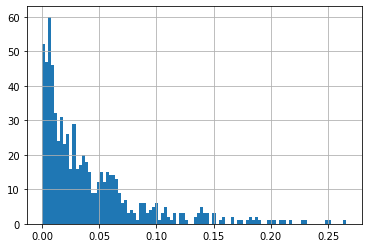

In [25]:
error["rel_error"].hist(bins=100)

Now, the great thing is that literally ALL OF THE ABOVE has been pacakged into a nice function for you, which returns both the trained model and this error dataframe! Simply run the `model_testing` function from the `mdp_model.py` file, and you will get these results!

## Visualization Tools

In the `mdp_testing.py` file, there are also various other visualization tools to help compare these results with real data! Most of these require you to have the original dataframe of the full data, as well as the clustered data which you can access at `model.df_trained`.

`plot_pred` allows us to visualize the predicted path of the model compared to the real evolution of the target value.

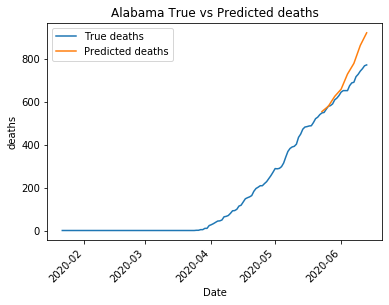

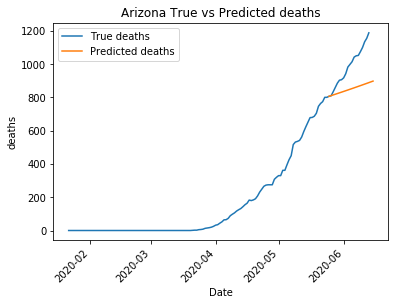

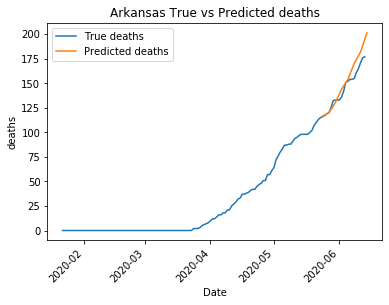

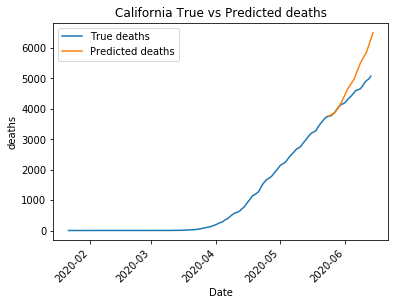

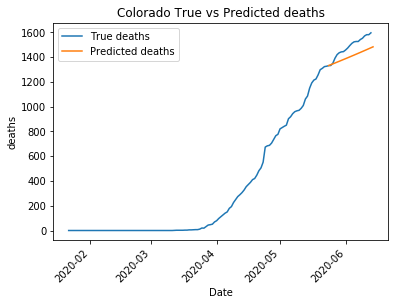

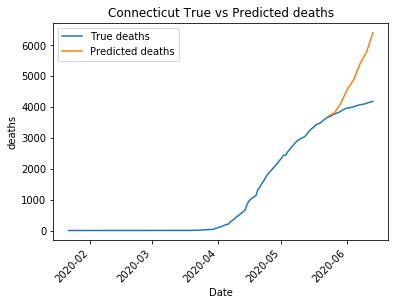

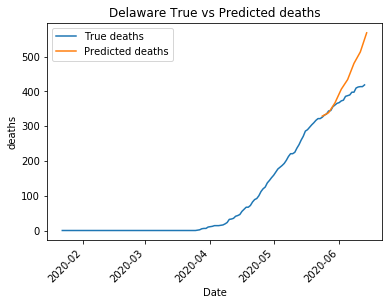

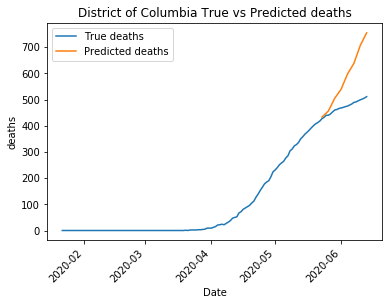

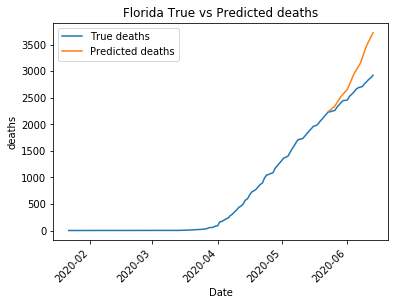

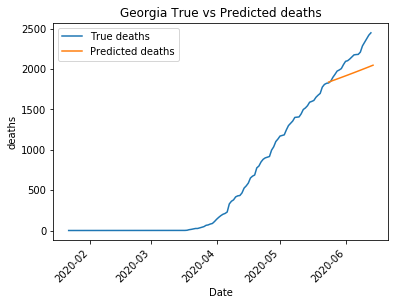

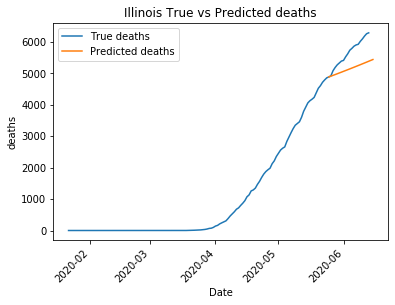

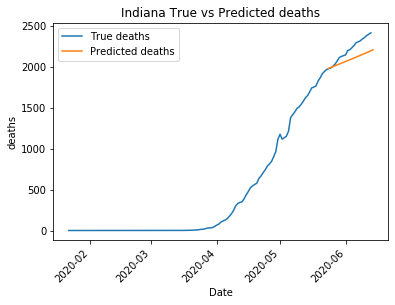

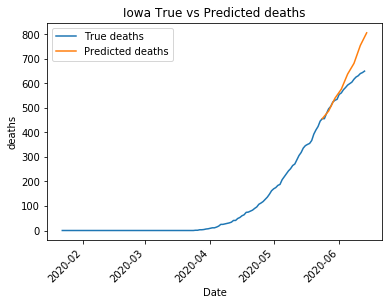

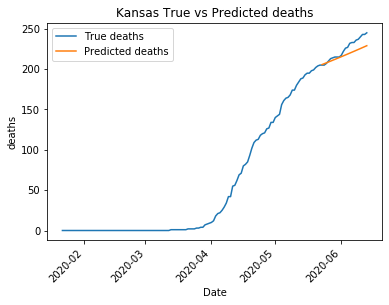

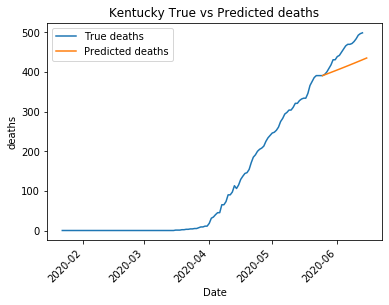

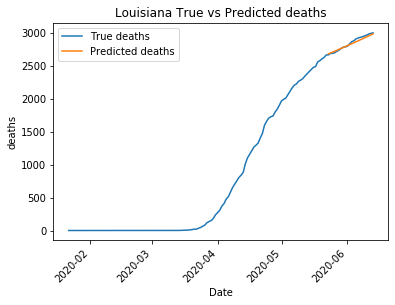

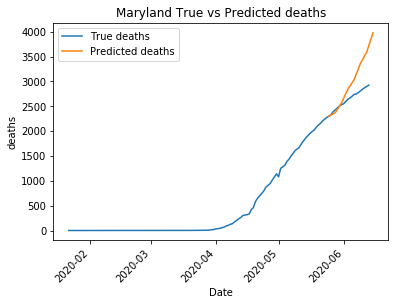

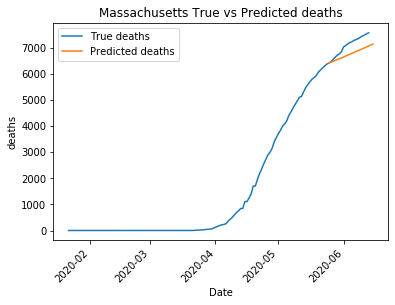

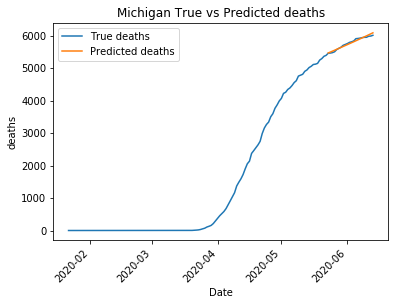

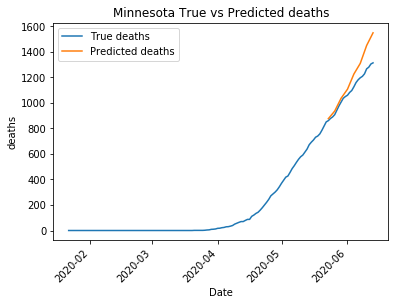

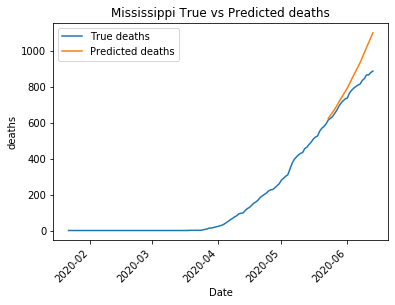

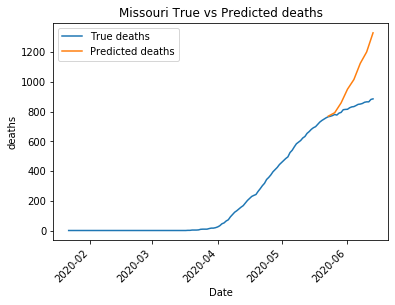

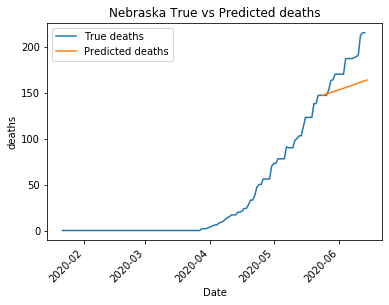

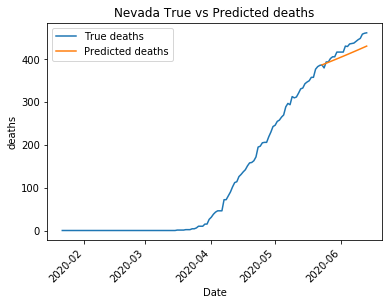

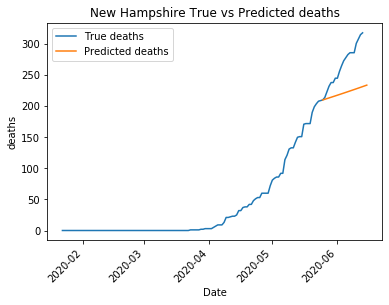

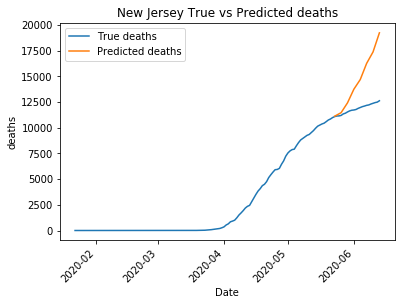

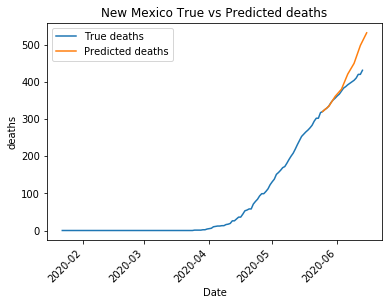

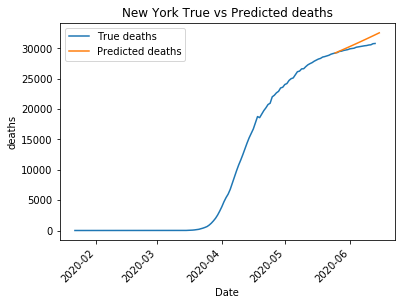

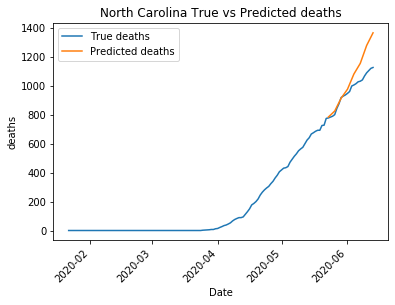

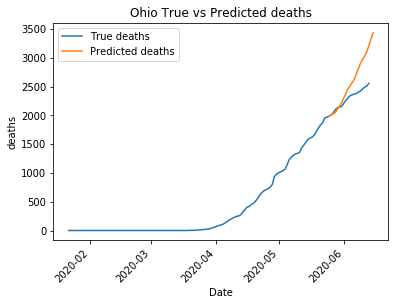

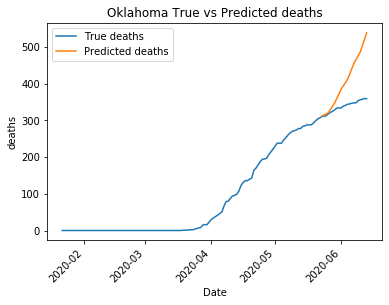

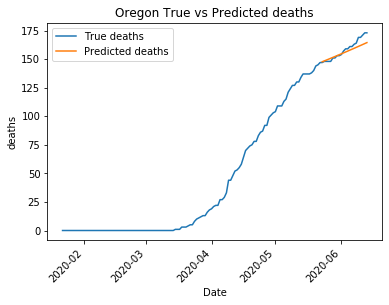

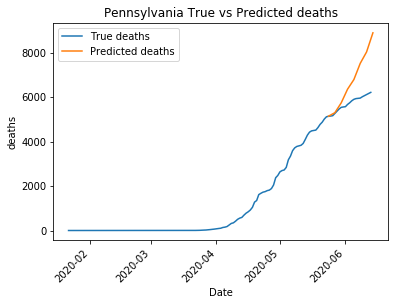

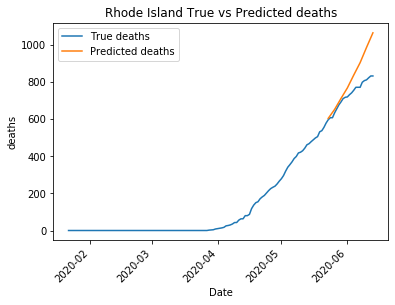

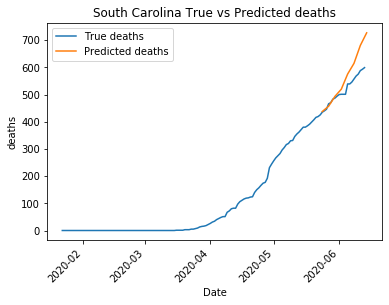

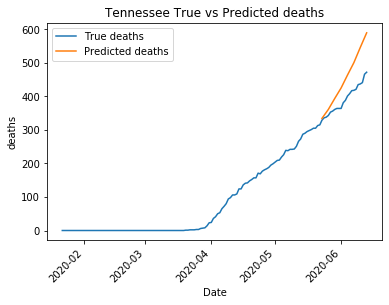

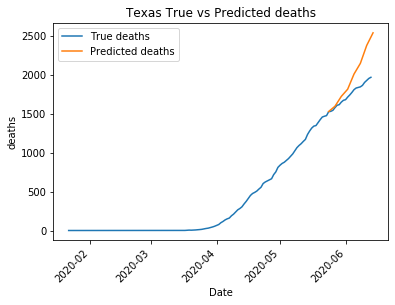

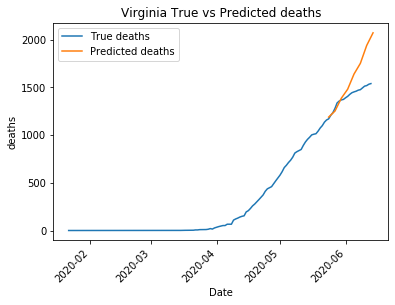

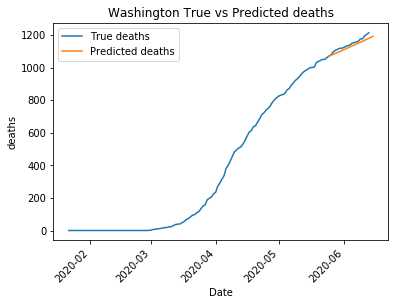

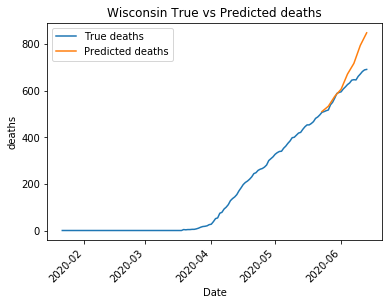

In [49]:
for region in m.df_trained.index:
    plot_pred(m, region, df, 20)

In [53]:
scd_waves = ['Arizona',
 'Alaska',
 'Nebraska',
 'New Hampshire',
 'Tennessee',
 'South Carolina',
 'North Carolina',
 'Winsconsin',
 'Rhodes Island',
 'Florida',
 'Arizona',
 'Alabama']

In [56]:
df_nan = df.loc[:, df.isnull().mean() < 0.1]
df_2nd_waves = df_nan[df_nan.state.isin(scd_waves)]

In [57]:
df_2nd_waves.head()

,Unnamed: 0,state,date,cases,deaths,population,emergdec,schoolclose,gathrestrict25,gathrestrictany,...,gathrestrict50,gathrecomany,gathrestrict250,gathrestrict5,gathrestrict1000,gathrestrict100,gathrestrict3,travelrestrictexit,travelrestrictentry,gathrestrict500
0,0,Alabama,2020-01-22,0,0,4903185.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Alabama,2020-01-23,0,0,4903185.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,Alabama,2020-01-24,0,0,4903185.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,Alabama,2020-01-25,0,0,4903185.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,Alabama,2020-01-26,0,0,4903185.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


ValueError: operands could not be broadcast together with shapes (2,) (29,) 